In [1]:
!python --version

Python 3.10.9


### Environnement d'exécution

In [2]:
import matplotlib.pyplot as plt
import numpy             as np

### Premier exemple : compression verticale d'un domaine rectangulaire

In [3]:
def phi(X):
    x, y = X
    var = 0.25 *np.asarray([(1.0-x)*(1.0-y), (1.0+x)*(1.0-y), (1.0+x)*(1.0+y), (1.0-x)*(1.0+y)])
    return var


def gradphi(X):
    x, y = X
    var = 0.25*np.asarray([
        [ -(1.0-y),  (1.0-y), (1.0+y), -(1.0+y) ],
        [ -(1.0-x), -(1.0+x), (1.0+x),  (1.0-x) ]
    ])
    return var

On paramètre le domaine rectangulaire par sa largeur `lx` et sa hauteur `ly`.

In [4]:
lx = 10.
ly = 50.

On rentre le nombre d'éléments par directions.

In [5]:
nelx = 9
nely = 49

On en déduit le nombre de noeuds par direction : `nelx+1` et `nely+1` respectivement, ainsi que les distances entre deux noeuds : `dx = lx/nelx` et `dy = ly/nely`. Le nombre total de noeuds est `nnodes = (nelx+1) *(nely+1)`.

In [6]:
nnodesx = nelx+1
nnodesy = nely+1

nnodes  = nnodesx *nnodesy
nelems  = nelx *nely
dx      = lx /nelx
dy      = ly /nely

On peut maintenant construire le maillage uniforme du domaine rectangulaire. On commence par construire le conteneur représentant les coordonnées des noeuds.

In [7]:
nodes = []

for y in np.linspace(0, ly, nnodesy):
    for x in np.linspace(0, lx, nnodesx):
        nodes.append([x, y])

nodes = np.asarray(nodes)
nodes.shape

(500, 2)

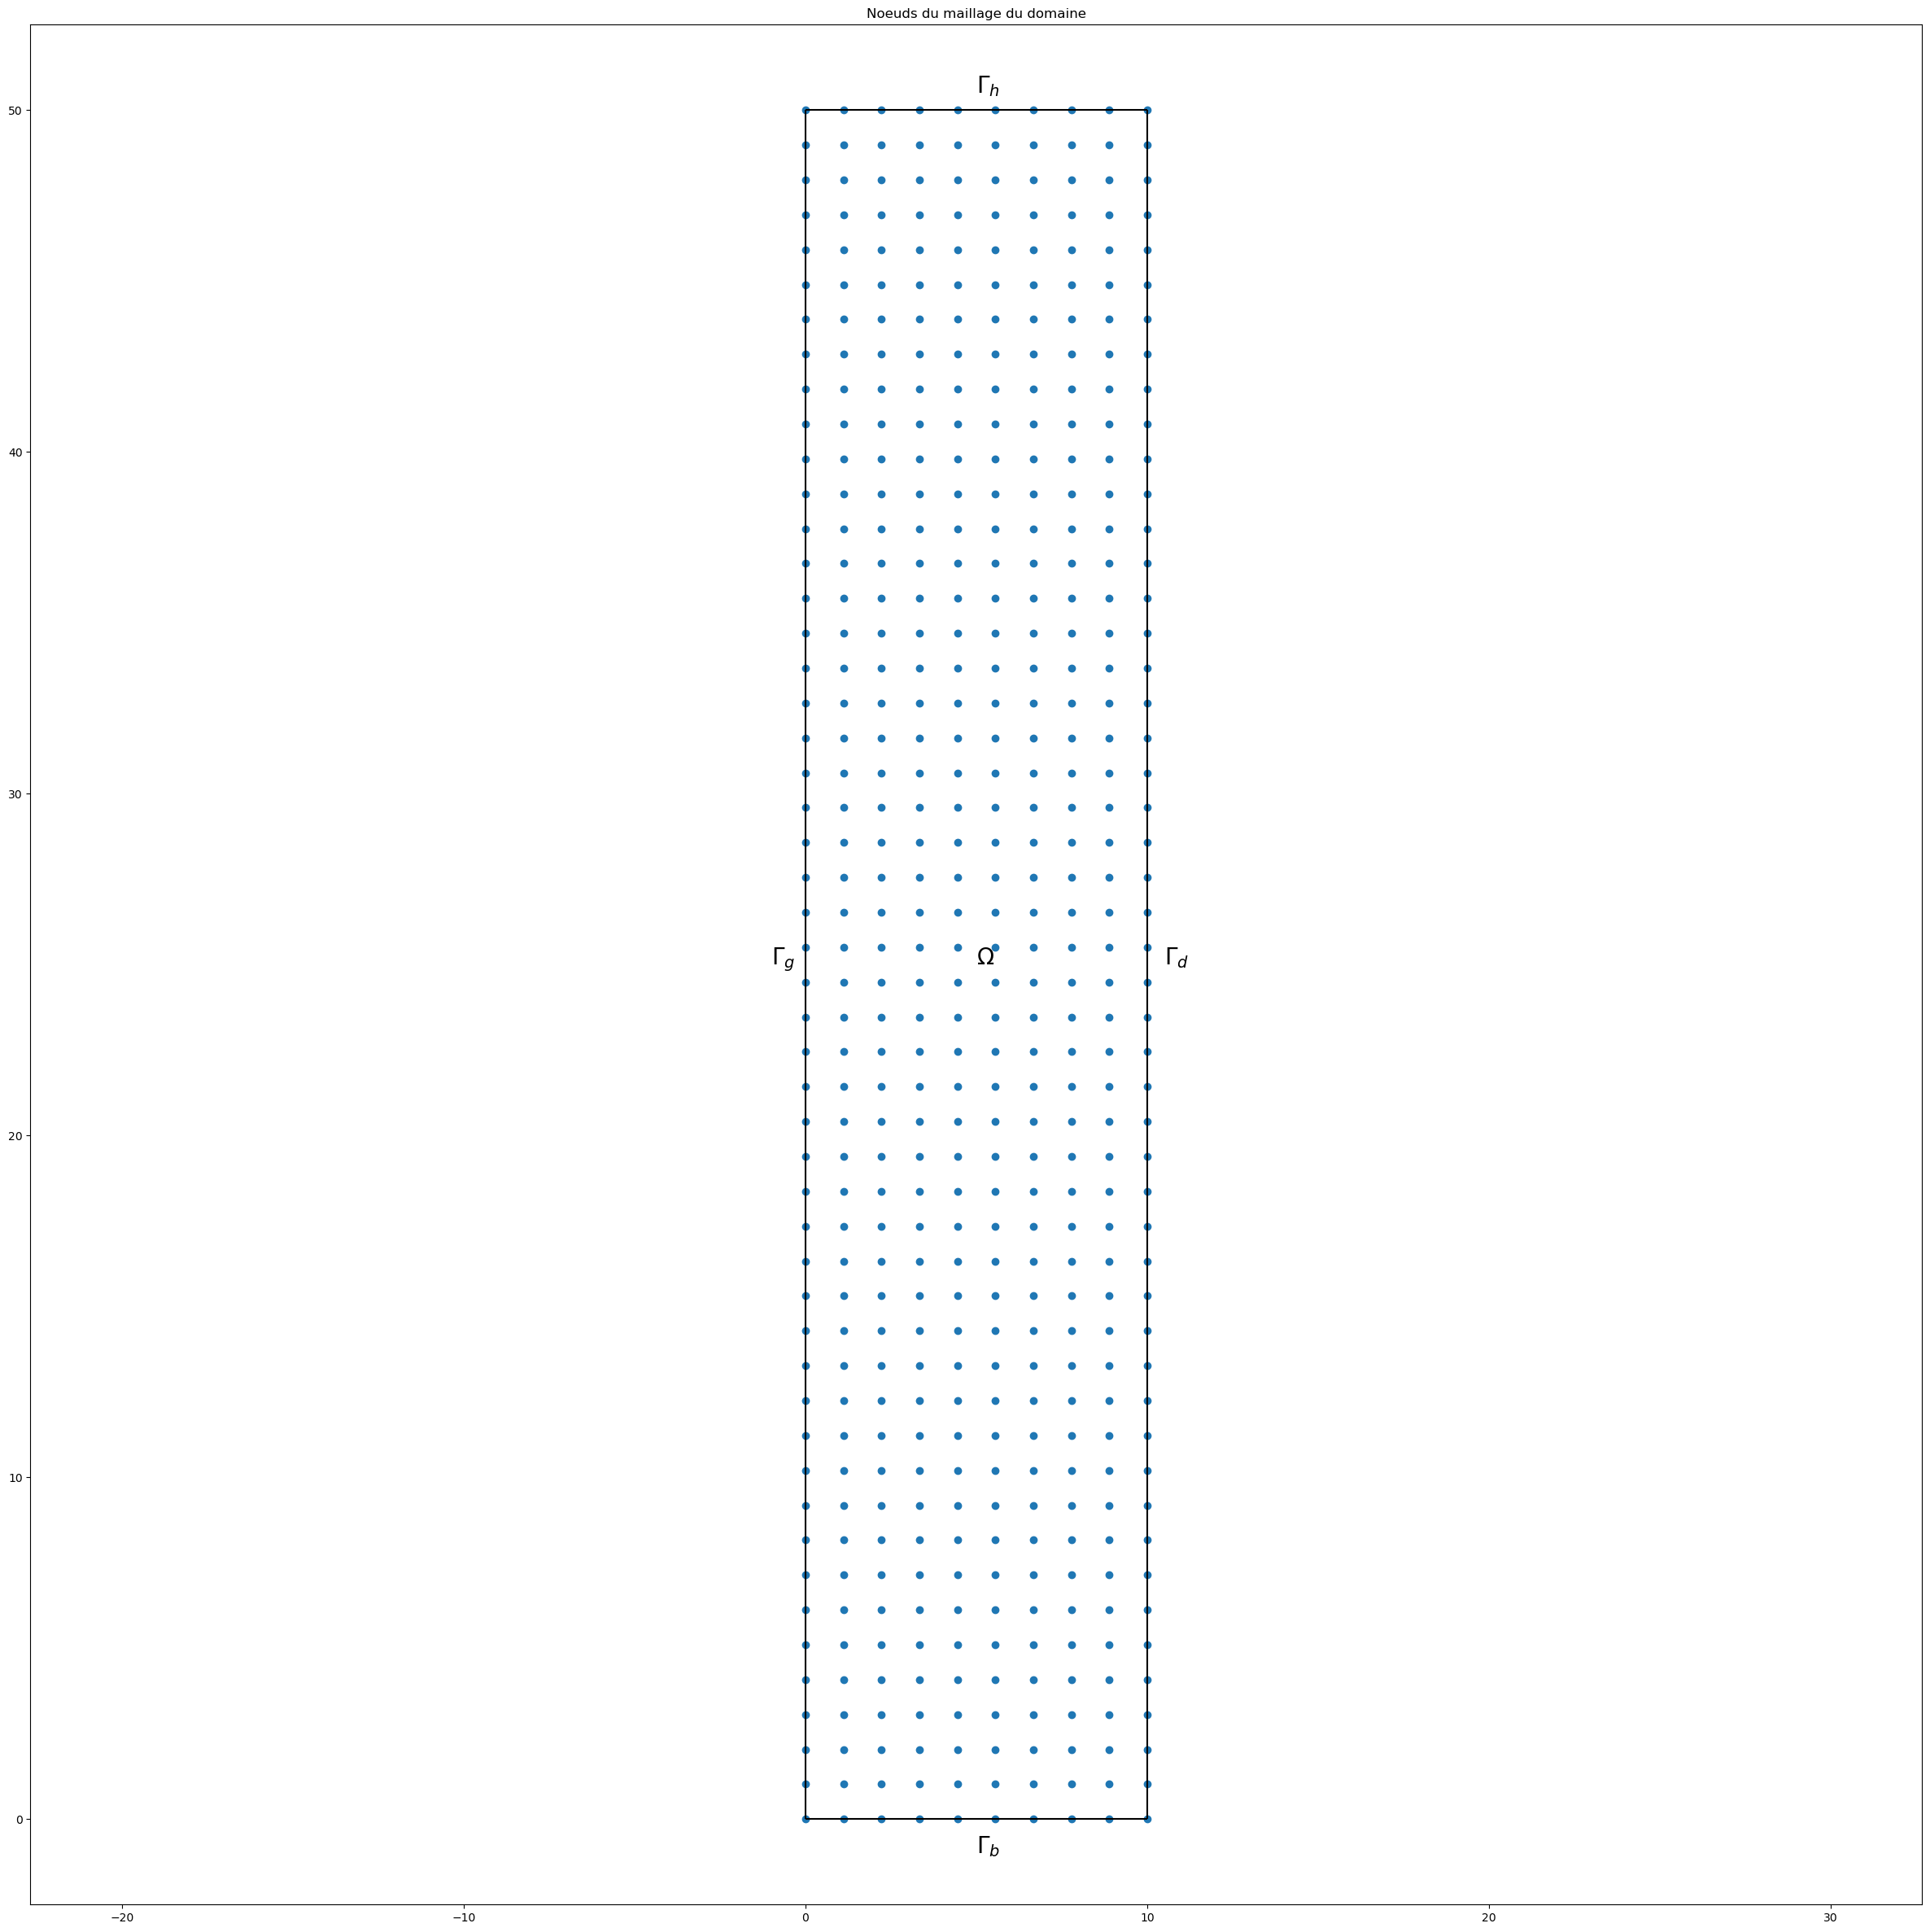

In [8]:
plt.figure(figsize=(30, 30))
plt.scatter(nodes[:,0], nodes[:,1])
plt.hlines(y=0,  xmin=0, xmax=lx, colors='black')
plt.text(x=lx/2, y=ly+.5, s=r"$\Gamma_h$", fontsize=20)
plt.vlines(x=lx, ymin=0, ymax=ly, colors='black')
plt.text(x=lx+.5, y=ly/2, s=r"$\Gamma_d$", fontsize=20)
plt.hlines(y=ly, xmin=0, xmax=lx, colors='black')
plt.text(x=lx/2, y=-1, s=r"$\Gamma_b$", fontsize=20)
plt.vlines(x=0,  ymin=0, ymax=ly, colors='black')
plt.text(x=-1, y=ly/2, s=r"$\Gamma_g$", fontsize=20)
plt.text(x=lx/2, y=ly/2, s=r"$\Omega$", fontsize=20)
plt.axis("equal")
plt.title("Noeuds du maillage du domaine")
plt.show()

On construit maintenant la table de connectivité permettant de définir des éléments rectangulaires.

In [9]:
conn = []

for j in range(nely):
    for i in range(nelx):
        id = i + j*nnodesx

        conn.append([id, id+1, id+1+nnodesx, id+nnodesx])

conn = np.asarray(conn)
conn.shape

(441, 4)

On peut enfin modéliser le comportement du matériau. Ici, on regarde un matériau linéaire isotrope en contraintes planes. On note `E` le module d'Young du matériau et `v` le coefficient de Poisson de celui-ci. La loi de comportement est représentée par une matrice `C`.

In [10]:
E = 100.
v = 0.48

C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v,     v,     0.0],
								      [    v, 1.0-v,     0.0],
								      [  0.0,   0.0,   0.5-v]])

On passe à l'assemblage de la matrice de raideur globale `K`. On commence par déclarer le conteneur, on l'initialise à 0, avant de le remplir.

In [11]:
K = np.zeros((2*nnodes,2*nnodes))

On choisit la formule de quadrature de Gauss qui s'écrit, pour un élément de référence, avec les coordonnées : $\left(\frac{-1}{\sqrt{3}}; \frac{-1}{\sqrt{3}}\right), \left(\frac{1}{\sqrt{3}}; \frac{-1}{\sqrt{3}}\right), \left(\frac{-1}{\sqrt{3}}; \frac{1}{\sqrt{3}}\right), \left(\frac{1}{\sqrt{3}}; \frac{1}{\sqrt{3}}\right)$

In [12]:
q4 = np.asarray([[x/np.sqrt(3.0), y/np.sqrt(3.0)] for y in [-1, 1] for x in [-1, 1]])
q4.shape

(4, 2)

On déclare une matrice `B` de taille $3 \times 8$ qui est un avatar discret de l'opérateur divergence $\nabla$.

In [13]:
B = np.zeros((3,8))

Pour tout élément, on assemble la matrice de raideur locale, qu'on injecte (par sommation) dans la matrice de raideur globale.

In [14]:
for el in conn:
    
    xIe = nodes[el, :]
    Ke  = np.zeros((8,8))

    for q in q4:
        dN = gradphi(q)
        J  = np.dot(dN, xIe).T
        dN = np.dot(np.linalg.inv(J), dN)

        B[0, 0::2] = dN[0,:]
        B[1, 1::2] = dN[1,:]
        B[2, 0::2] = dN[1,:]
        B[2, 1::2] = dN[0,:]

        Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)

    for i, I in enumerate(el):
        for j, J in enumerate(el):
            K[2*I,2*J]     += Ke[2*i,2*j]
            K[2*I+1,2*J]   += Ke[2*i+1,2*j]
            K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
            K[2*I,2*J+1]   += Ke[2*i,2*j+1]

On applique à la matrice de raideur globale les conditions aux limites suivantes
- traction verticale sur le sommet du rectangle,
- blocage sur la base du rectangle,
- ???

Le sommet du rectangle se détecte à l'aide de la condition `nodes[i, 1] == ly` et sa base avec la condition `nodes[i, 1] == 0`. En effet : c'est une condition géométrique sur la coordonnée $y$ de chaque noeud, pour tout noeud indexé par `i`.

In [15]:
for i in range(nnodes):
    
    if nodes[i, 1] == 0.0:
        K[2*i,:]       = 0.0
        K[2*i+1,:]     = 0.0
        K[2*i,2*i]     = 1.0
        K[2*i+1,2*i+1] = 1.0

    else:
        continue

On peut créer le vecteur second membre, lequel représente le vecteur résultante des forces définie en chaque noeud du maillage. En principe, on pourrait l'intégrer dans l'itération précédente.

In [16]:
f = np.zeros((2*nnodes))

for i in range(nnodes):

    if nodes[i, 1] == ly:
        
        x = nodes[i,0]
        
        f[2*i+1] = 20.0
        
        if x == 0 or x == lx:
            f[2*i+1] *= 0.5

Le système linéaire étant assemblé, il n'y a plus qu'à résoudre le problème. On appelle ici le solveur linéaire de `numpy`, l'inconnue est le déplacement noté `u`.

In [17]:
u = np.linalg.solve(K, f)
u.shape

(1000,)

On reconstruit, par noeud, la grandeur vectorielle : le déplacement est un vecteur défini en chaque noeud avec deux composantes.

In [18]:
ux = np.reshape(u[0::2], (nnodesy,nnodesx))
uy = np.reshape(u[1::2], (nnodesy,nnodesx))
u  = np.asarray([ux, uy])
u.shape

(2, 50, 10)

Il n'y a plus qu'à post-traiter.

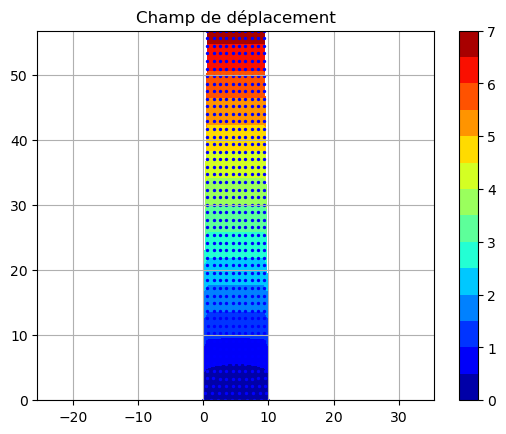

In [19]:
xvec = []
yvec = []
res  = []

for i in range(nnodesx):
    for j in range(nnodesy):
        xvec.append(i*dx + ux[j,i])
        yvec.append(j*dy + uy[j,i])
        res.append(uy[j,i])

t = plt.tricontourf(xvec, yvec, res, levels=14, cmap=plt.cm.jet)
plt.scatter(xvec, yvec, marker='o', c='b', s=2)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.title("Champ de déplacement")
plt.show()

Code proposé par Jorgen Bergstrom :

- https://polymerfem.com/full-finite-element-solver-in-100-lines-of-python/